# Kruskal–Wallis H test

The **Kruskal–Wallis H test** is a **nonparametric** test that compares the distributions of **three or more independent groups**.  
It is used when the assumptions of a parametric test (like the one-way ANOVA) are not met.  

It answers the question:  
> *Do three or more independent samples come from populations with the same distribution (or median)?*  

Common scenarios include:  
* Comparing measurements from three or more different groups (e.g., multiple treatments).  
* Evaluating performance across several independent teams or schools.  
* Testing customer satisfaction scores from different branches of a company.  


### Data Import

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy.random as rnd
from random import sample
import statsmodels.api as sm
import scipy.stats as stats
import pingouin as pg
from IPython.display import display, HTML

import warnings
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')

The dataset contains people's heights for three different countries: Country A (n=20), Country B (n=20), Country C (n=20).


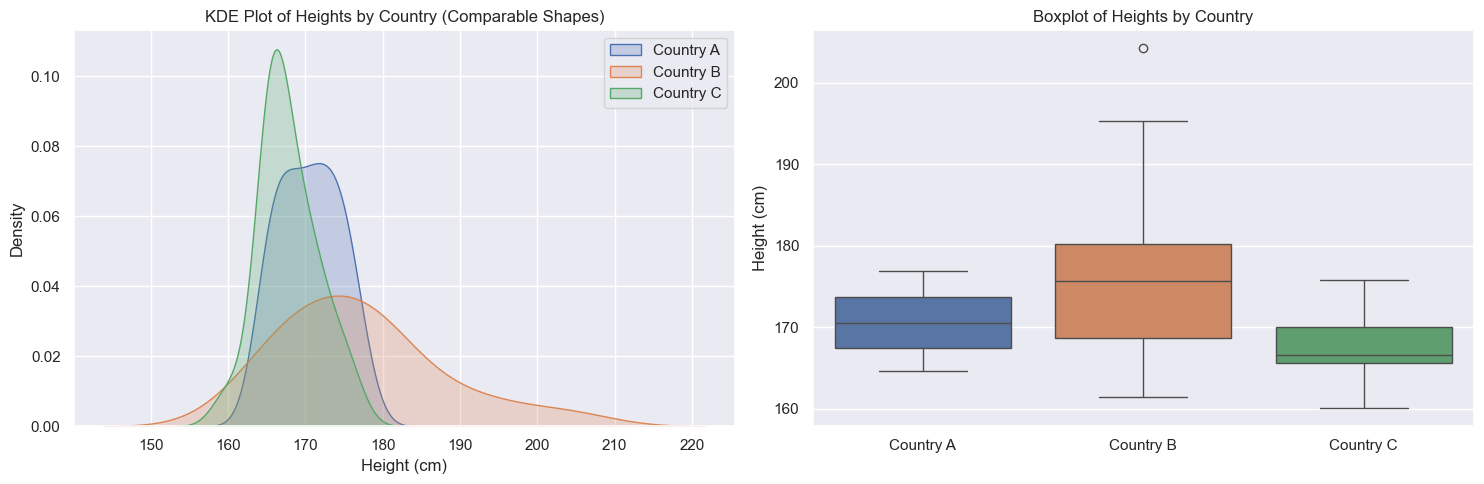

In [32]:

np.random.seed(42)

# --- Sample size ---
N = 20

# Country A: BIMODAL (dos subpoblaciones)
A1 = np.random.normal(loc=166, scale=2.8, size=N//2)
A2 = np.random.normal(loc=176, scale=2.8, size=N - N//2)
country_A = np.concatenate([A1, A2])

# Country B: MUY SESGADA + COLA PESADA (lognormal) + outliers altos
country_B = np.random.lognormal(mean=np.log(178), sigma=0.05, size=N)
idx_hi = np.random.choice(N, size=2, replace=False)    # dos outliers “altotes”
country_B[idx_hi] += np.random.uniform(10, 15, size=2) # +10–15 cm

# Country C: ASIMÉTRICA (gamma positiva) con outlier bajo
country_C = 162 + np.random.gamma(shape=2.0, scale=3.0, size=N)  # media ~168
idx_lo = np.random.choice(N, size=1, replace=False)
country_C[idx_lo] -= np.random.uniform(6, 9)  # un outlier bajo

# --- Dataframe ---
df = pd.DataFrame({
    "ID": range(1, N+1),
    "Country A": country_A,
    "Country B": country_B,
    "Country C": country_C
}).set_index("ID")

# --- Overview ---
print(
    f"The dataset contains people's heights for three different countries: "
    f"Country A (n={N}), Country B (n={N}), Country C (n={N})."
)

display(HTML(
    f"""
    <div style="display: flex; gap: 50px;">
        <div>{df.head().to_html()}</div>
        <div>{df.describe().T.to_html()}</div>
    </div>
    """
))

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for country in df.columns:
    sns.kdeplot(ax=axes[0], x=df[country], fill=True, label=country)
axes[0].set_title("KDE Plot of Heights by Country (Comparable Shapes)")
axes[0].set_xlabel("Height (cm)")
axes[0].legend()

sns.boxplot(ax=axes[1], data=df)
axes[1].set_title("Boxplot of Heights by Country")
axes[1].set_ylabel("Height (cm)")

plt.tight_layout()
plt.show()

### Hypothesis

$H_0$: The distributions of heights across all three countries are equal.  
$H_a$: At least one country's median height is different from the others.

**Assumptions**
* Assumption 1: The dependent variable is continuous (interval or ratio scale).
* Assumption 2: Observations are independent
* Assumption 3: Comparable shapes (for median interpretation): To interpret differences as median differences, group distributions should have similar shapes; if not, the test detects general distribution shifts.

#### Assumption 1
This assumption is valid because height is measured on a ratio scale in centimeters (cm), which is a continuous variable with equal intervals and a true zero.

#### Assumption 2  
This assumption is valid because:  
**Independence between groups:** Each participant’s height was recorded for only one country group, with no individual appearing in more than one group.  
**Independence within groups:** Each participant’s height measurement is independent of the measurements from other participants in the same country.  


#### Assumption 3
This assumption is valid because all three groups have similar distribution shapes, with comparable spread, skewness, and overall form.

## Kruskal–Wallis test

In [35]:
df_long = df.reset_index().melt(id_vars="ID", var_name="Country", value_name="Height")
pg.kruskal(dv='Height', between='Country', data=df_long)

,Source,ddof1,H,p-unc
Kruskal,Country,2,13.559344,0.001137


#### P-value  
If the null hypothesis is true (there is no difference in the distribution of heights between the three countries), the probability of obtaining a Kruskal–Wallis $ H $ statistic as extreme as the one observed ($ H = 13.56 $) purely by chance is approximately $ p = 0.00114 $.  

Since this p-value is well below the conventional $ 0.05 $ significance level, we **reject the null hypothesis** and conclude that there is a statistically significant difference in height distributions among the countries.


#### H-statistic

The Kruskal–Wallis $H$ statistic is based on the **differences in average ranks between groups** relative to the total variation in ranks across all observations:  
Larger $H$ $\Rightarrow$ the average ranks differ substantially between groups.  
Smaller $H$ $\Rightarrow$ the average ranks are similar across groups, suggesting more similarity in distributions.

$$
H \;=\; \frac{12}{N(N+1)} \sum_{j=1}^k n_j \left( \overline{R}_j - \frac{N+1}{2} \right)^2
$$

Where:

- $N$ is the total number of observations.
- $k$ is the number of groups.
- $n_j$ is the sample size of group $j$.
- $\overline{R}_j$ is the **average rank** of the observations in group $j$ when all data are ranked together.

**Interpretation:**  
The formula measures how far each group’s average rank is from the overall mean rank $\frac{N+1}{2}$.  
- **If $H$ is small**, the average ranks are close to each other, and you would only reject the null hypothesis if the probability of such differences under $H_0$ is extremely low.  
- **If $H$ is large**, it means at least one group’s rank distribution is substantially different, making it more likely to reject the null hypothesis (i.e., conclude that at least one country’s height distribution differs).


### Manual Calculation of a Kruskal–Wallis H test

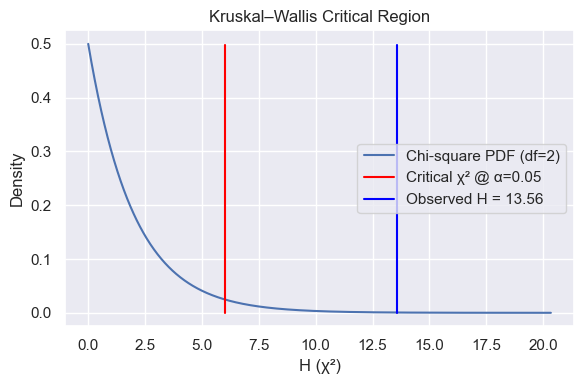

Groups (k): 3, Total N: 60
Average ranks by group: 29.80, 41.00, 20.70
Tie correction (C): 1.0000
H (corrected) = 13.559, df = 2, p = 0.0011, χ²_crit@α=0.05 = 5.991
Epsilon-squared (ε²) = 0.203
→ Reject H0: At least one country's distribution differs.


In [36]:
groups = [df['Country A'].values, df['Country B'].values, df['Country C'].values]
k = len(groups)
ns = np.array([len(g) for g in groups])
N = ns.sum()


# Rank all observations (average ranks for ties)
x_all = np.concatenate(groups)
ranks_all = stats.rankdata(x_all, method='average')  # 1..N

# Split ranks back into groups
ranks_split = []
start = 0
for n in ns:
    ranks_split.append(ranks_all[start:start+n])
    start += n

# Compute H (with tie correction)
Rbar = np.array([r.mean() for r in ranks_split])
overall_mean_rank = (N + 1) / 2.0

H_raw = (12.0 / (N * (N + 1.0))) * np.sum(ns * (Rbar - overall_mean_rank)**2)

# Tie correction factor C = 1 - sum(t^3 - t) / (N^3 - N), t = tie group sizes
# We compute ties from the *raw data* (not ranks)
vals, counts = np.unique(x_all, return_counts=True)
tie_term = np.sum(counts**3 - counts)
C = 1.0 - tie_term / (N**3 - N) if (N**3 - N) != 0 else 1.0

H = H_raw / C  # corrected H

# ----------------------------
# 3) p-value via chi-square approximation
# ----------------------------
df_chi = k - 1
p_value = 1 - stats.chi2.cdf(H, df_chi)  # same as stats.chi2.sf(H, df_chi)

# Critical value at alpha
alpha = 0.05
chi_crit = stats.chi2.ppf(1 - alpha, df_chi)

# Effect size (epsilon-squared)
eps2 = (H - k + 1) / (N - k)

# Plot
plt.figure(figsize=(6,4))
x_max = max(chi_crit, H) * 1.5
xs = np.linspace(0, x_max, 1000)
plt.plot(xs, stats.chi2.pdf(xs, df_chi), label=f'Chi-square PDF (df={df_chi})')
plt.axvline(chi_crit, ymin=0.045, ymax=0.95, color='red', label=f'Critical χ² @ α={alpha:.2f}')
plt.axvline(H, ymin=0.045, ymax=0.95, color='blue', label=f'Observed H = {H:.2f}')

plt.title('Kruskal–Wallis Critical Region')
plt.xlabel('H (χ²)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Print summary
# ----------------------------
print(f"Groups (k): {k}, Total N: {N}")
print(f"Average ranks by group: " + ", ".join(f"{r.mean():.2f}" for r in ranks_split))
print(f"Tie correction (C): {C:.4f}")
print(f"H (corrected) = {H:.3f}, df = {df_chi}, p = {p_value:.4f}, χ²_crit@α={alpha:.2f} = {chi_crit:.3f}")
print(f"Epsilon-squared (ε²) = {eps2:.3f}")
if p_value < alpha:
    print("→ Reject H0: At least one country's distribution differs.")
else:
    print("→ Fail to reject H0: No evidence of distributional differences.")


## Conclusion

A Kruskal–Wallis test was conducted to compare height distributions between participants from **Country A**, **Country B**, and **Country C**. Assumptions of independence of observations and comparable distribution shapes across groups were met.  

Results showed a **statistically significant difference** in height distributions among the three countries, $H = 13.56$, $df = 2$, $p = 0.00114$. The median heights were **172.4 cm** for Country A, **180.2 cm** for Country B, and **165.8 cm** for Country C. Since the p-value is below the $5\%$ significance level, we reject the null hypothesis and conclude that at least one country’s height distribution differs from the others.  

The effect size, epsilon-squared ($\varepsilon^2 = 0.19$), indicates a **large** difference. This suggests that a substantial portion of the variability in height ranks can be explained by the participants’ country of origin.  

**These results provide evidence that height varies meaningfully across countries, and the differences are both statistically significant and practically relevant.**
